In [1]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    assert int(torch.__version__.split(".")[0])>1 or (int(torch.__version__.split(".")[0])>2 and int(torch.__version__.split(".")[1]) >= 12), "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    # print(f"torch version: {torch.__version__}")
    # print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0
torchvision version: 0.18.0


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

/home/joseph/miniconda3/envs/clip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper (4096) but it's because we're starting small # we can always scale up later

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

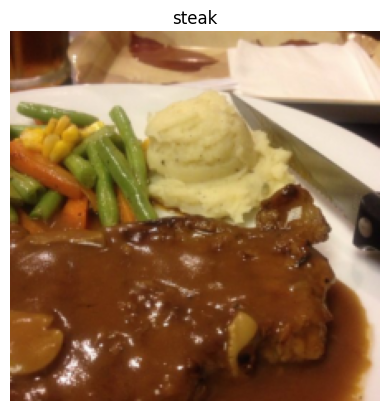

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);


In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height*width)/patch_size**2)
number_of_patches

196

In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)") # 2D image flattened into patches = 1D sequence of patches

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


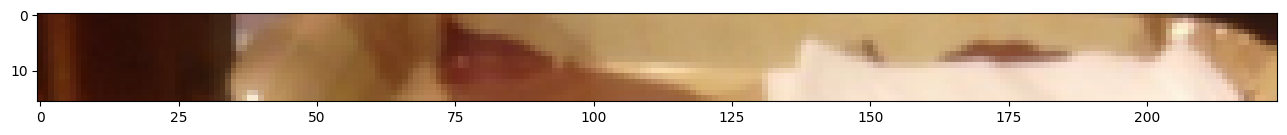

In [12]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

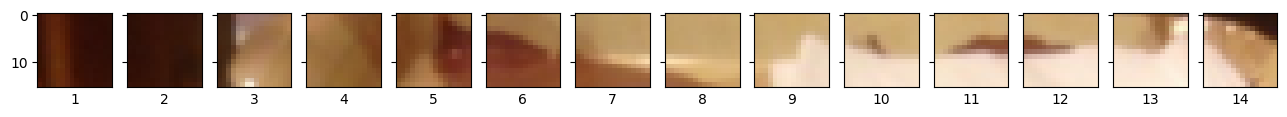

In [13]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size//patch_size,                    # one column for each patch
                        sharex=True, sharey=True,
                        figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
#   axs[i].set_yticks([])
       # keep height index constant, alter the width index

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches : 196.0  
Patch size: 16 pixels x 16 pixels


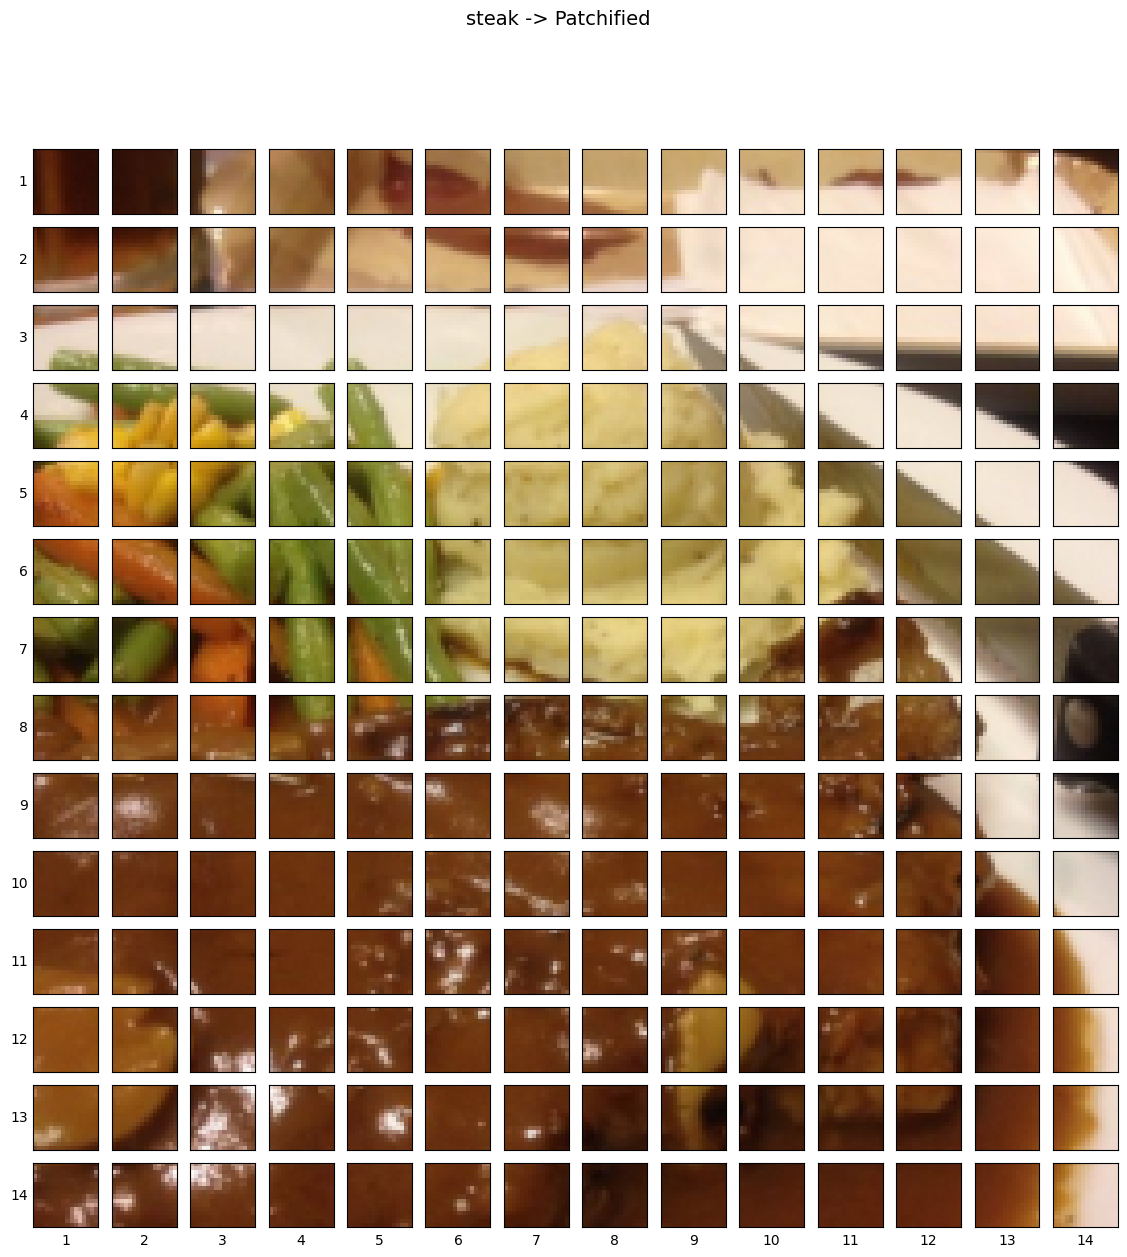

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches : {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size//patch_size,
                        ncols=img_size//patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)
                        # need int not float

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):   # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
      # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
      axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                      patch_width:patch_width+patch_size, # iterate through width
                                      :])# get all color channels

      # Set up label information, remove the ticks for clarity and set labels to outside
      axs[i, j].set_ylabel(i+1,
                           rotation="horizontal",
                           horizontalalignment="right",
                           verticalalignment="center")
      axs[i, j].set_xlabel(j+1)
      axs[i, j].set_xticks([])
      axs[i, j].set_yticks([])
      axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

In [15]:
# Creating image patches with torch.nn.Conv2d()
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

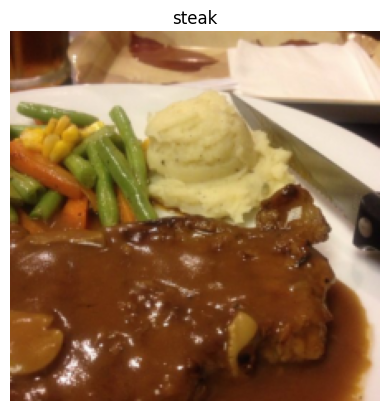

In [16]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [17]:
print(image.shape)
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


In [18]:
image_out_of_conv.requires_grad

True

Showing random convlutional feature maps from indexes: [121, 367, 308, 100, 708]


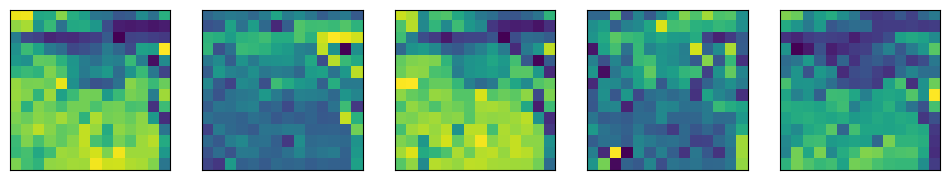

In [19]:
import random
random_indexes = random.sample(range(0,768), k=5)
print(f"Showing random convlutional feature maps from indexes: {random_indexes}") # pick 5 numbers between 0 and the embedding size

fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:,idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(tensor([[[-0.0431, -0.0391, -0.0376, -0.1938, -0.0733, -0.1262, -0.1376,
           -0.2298, -0.2503, -0.2259, -0.2526, -0.2602, -0.2355, -0.1826],
          [-0.0289, -0.0519, -0.1325, -0.1364, -0.2338, -0.1334, -0.1148,
           -0.0961, -0.2145, -0.3462, -0.3437, -0.3404, -0.3420, -0.3387],
          [-0.1676, -0.3389, -0.3113, -0.2632, -0.3451, -0.3295, -0.3040,
           -0.2980, -0.2754, -0.4078, -0.3135, -0.3851, -0.3895, -0.4004],
          [-0.3278, -0.0800, -0.1500, -0.2837, -0.3064, -0.3204, -0.2860,
           -0.2829, -0.2683, -0.1651, -0.3629, -0.3163, -0.0713, -0.0407],
          [-0.1081, -0.2155, -0.1404, -0.2097, -0.1139, -0.2274, -0.2066,
           -0.2517, -0.2218, -0.2107, -0.1212, -0.3166, -0.3634, -0.2931],
          [-0.0698, -0.2106, -0.0311, -0.1241, -0.1271, -0.0617, -0.2567,
           -0.1989, -0.1623, -0.2359, -0.3014, -0.1270, -0.1723, -0.3750],
          [-0.1354, -0.1204, -0.0278, -0.0108, -0.0485, -0.1618, -0.2628,
           -0.2922, -0.2631, -0.

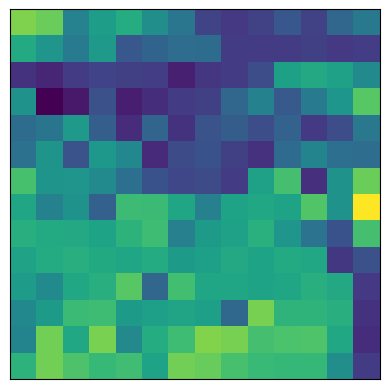

In [20]:
plt.xticks([]), plt.yticks([])

# single feature map (in tensor form)
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad, plt.imshow(image_conv_feature_map.squeeze().detach().numpy())

In [21]:
# Create flatten layer
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,  # flatten feature_map_height (dimension 2)
                           end_dim=3)    # flatten feature_map_width (dimension 3)
flattened_image_out_of_conv = flatten_layer(image_out_of_conv)

flattened_image_out_of_conv.shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


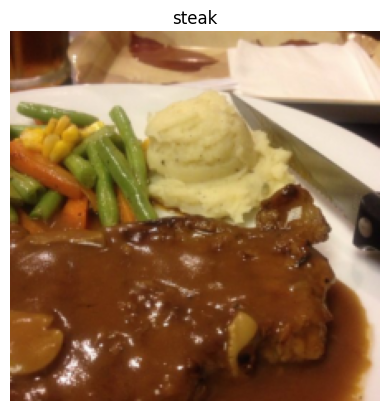

In [22]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


In [23]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


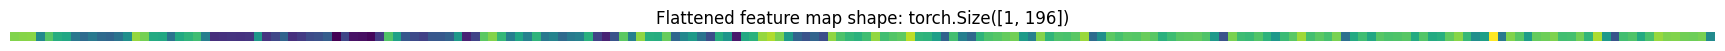

In [24]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [25]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.0431, -0.0391, -0.0376, -0.1938, -0.0733, -0.1262, -0.1376, -0.2298,
          -0.2503, -0.2259, -0.2526, -0.2602, -0.2355, -0.1826, -0.0289, -0.0519,
          -0.1325, -0.1364, -0.2338, -0.1334, -0.1148, -0.0961, -0.2145, -0.3462,
          -0.3437, -0.3404, -0.3420, -0.3387, -0.1676, -0.3389, -0.3113, -0.2632,
          -0.3451, -0.3295, -0.3040, -0.2980, -0.2754, -0.4078, -0.3135, -0.3851,
          -0.3895, -0.4004, -0.3278, -0.0800, -0.1500, -0.2837, -0.3064, -0.3204,
          -0.2860, -0.2829, -0.2683, -0.1651, -0.3629, -0.3163, -0.0713, -0.0407,
          -0.1081, -0.2155, -0.1404, -0.2097, -0.1139, -0.2274, -0.2066, -0.2517,
          -0.2218, -0.2107, -0.1212, -0.3166, -0.3634, -0.2931, -0.0698, -0.2106,
          -0.0311, -0.1241, -0.1271, -0.0617, -0.2567, -0.1989, -0.1623, -0.2359,
          -0.3014, -0.1270, -0.1723, -0.3750, -0.1354, -0.1204, -0.0278, -0.0108,
          -0.0485, -0.1618, -0.2628, -0.2922, -0.2631, -0.3001, -0.0319, -0.0828,
          -0.108

In [26]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels=3,
                 patch_size=16,
                 embedding_dim=768):
    
        super().__init__()
        
        self.patch_size = patch_size
        
        # Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        
        # Create a layer to flatten the patches
        self.flatten = nn.Flatten(2,3) # only flatten the feature map dimensions into a single vector

    # Forward Method
    def forward(self, x):
        image_resolution = x.shape[-1] # image resolution check
        assert image_resolution % patch_size == 0, f"Image resolution {image_resolution} must be divisible by patch size {self.patch_size}" # 나뉘어야 함, 아닐 경우 print
        
        # forward pass
        x_flattened = self.flatten(self.patcher(x))
        
        return x_flattened.permute(0,2,1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N (number of patches), P^2•C (embedding_dimension)]
    

In [27]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through PatchEmbedding
print(image.unsqueeze(0).shape)
patch_embedded_image = patchify(image.unsqueeze(0))
print(patch_embedded_image.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])


In [28]:
random_input_image = (1,3,224,224)

summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [29]:
patch_embedded_image, patch_embedded_image.shape

(tensor([[[-0.1988, -0.0233, -0.0548,  ...,  0.0824, -0.0347,  0.1530],
          [-0.1724,  0.0013, -0.0278,  ...,  0.0742, -0.0772,  0.0634],
          [-0.6284,  0.1045, -0.1421,  ...,  0.4685, -0.2449,  0.1397],
          ...,
          [-0.2891, -0.0113, -0.0256,  ...,  0.1193, -0.1440,  0.1082],
          [-0.4271,  0.0208, -0.0148,  ...,  0.2240, -0.2124,  0.1149],
          [-0.9462,  0.3832, -0.2379,  ...,  0.5651, -0.2679,  0.1712]]],
        grad_fn=<PermuteBackward0>),
 torch.Size([1, 196, 768]))

In [30]:
# Make learnable class token, add it to the number_of_patches dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token, class_token.shape

(Parameter containing:
 tensor([[[-2.4663e+00,  4.8666e-01,  8.1275e-01,  3.2980e-01, -1.6121e+00,
           -5.7590e-01, -2.2805e-01,  2.9429e-01,  1.1967e-01,  1.5855e+00,
           -2.9088e-01, -1.1353e+00,  1.4488e+00, -1.8383e+00,  8.0495e-01,
           -6.1171e-01, -2.0441e+00,  6.1023e-01,  8.8660e-01,  2.9294e+00,
            1.0633e+00,  1.9676e+00, -2.5913e-01,  4.3707e-01,  2.1142e+00,
            1.0478e+00, -3.8597e-01, -1.0752e+00, -8.8747e-01, -5.0138e-01,
            1.3277e+00,  1.1156e+00, -1.0734e+00, -1.5635e-01, -1.0746e-01,
            7.7948e-01, -1.6764e+00, -9.8822e-01,  5.4542e-01, -1.2481e-01,
           -2.7308e-01, -1.0960e+00, -2.7923e-01,  3.1009e-01, -7.9536e-03,
            7.0091e-01, -9.8159e-02,  1.5224e+00, -3.0794e-01, -8.6819e-01,
           -4.4327e-01,  1.8111e+00,  1.5676e+00, -7.6208e-01,  2.2796e-01,
           -2.7188e-01, -4.5235e-01, -7.5575e-01, -1.0747e+00, -8.1149e-01,
           -1.0482e+00, -3.1524e-01,  3.0454e+00, -4.0238e-01, -2

In [31]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
print(f'patch_embedded_image_with_class_embedding : {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]')

patch_embedded_image_with_class_embedding : torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [32]:
number_of_patches = int((height*width)/patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(batch_size,
                                                    number_of_patches+1,
                                                    embedding_dimension,
                                                    requires_grad=True))

# Show first 10 sequences and 10 position embedding values, check shape of position embedding
print(position_embedding[:10])
print(f"Position embedding sequence shape: {position_embedding.shape} -> [batch_size, number_of_patches+1, embedding_dimension]")

tensor([[[-0.7411,  0.8154, -0.3632,  ...,  1.1716, -0.6841, -1.8584],
         [-0.6329,  0.6017,  0.7737,  ..., -0.4305, -1.1761,  0.5040],
         [ 0.4181, -0.8031,  0.6838,  ..., -0.1055,  1.2080, -1.1675],
         ...,
         [-0.2004, -2.7290, -0.4892,  ..., -1.7061,  0.1665,  1.2587],
         [ 0.4338,  0.2027,  0.7711,  ..., -0.2499, -0.6855, -0.0338],
         [-1.7389,  0.7569, -1.0380,  ..., -1.5983, -0.1549,  0.4573]]],
       grad_fn=<SliceBackward0>)
Position embedding sequence shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches+1, embedding_dimension]


In [33]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding[:1], patch_and_position_embedding.shape

(tensor([[[-3.2074,  1.3021,  0.4496,  ...,  2.0919, -0.4471, -0.3826],
          [-0.8317,  0.5784,  0.7189,  ..., -0.3481, -1.2107,  0.6570],
          [ 0.2457, -0.8018,  0.6560,  ..., -0.0313,  1.1308, -1.1041],
          ...,
          [-0.4895, -2.7403, -0.5149,  ..., -1.5867,  0.0225,  1.3669],
          [ 0.0067,  0.2235,  0.7564,  ..., -0.0259, -0.8979,  0.0811],
          [-2.6851,  1.1401, -1.2760,  ..., -1.0332, -0.4228,  0.6285]]],
        grad_fn=<SliceBackward0>),
 torch.Size([1, 197, 768]))

1. Set patch size : 16
2. Single image shape, height, width
3. Add batch dimension to the single image (PatchEmbedding layer compatibility)
4. Create PatchEmbedding layer
5. Passing single image through PatchEmbedding layer (Create patch embeddings)
6. Create class token embedidng
7. Prepend class token embedding to the patch embeddings
8. Create position embedding (series of 1D learnable tokens)
9. Add position embedding to class token + patch embeddings

In [34]:
set_seeds()
#1
patch_size = 16

#2
print(f'Image tensor shape:{image.shape}')
height, width = image.shape[1], image.shape[2]

#3
x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')

#4
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                patch_size=patch_size,
                                embedding_dim=768)

#5
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape:{patch_embedding.shape}')

#6
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)


print(f'Class token shape: {class_token.shape}')

#7
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding with class token shape: {patch_embedding_class_token.shape}')

#8
token_shape = patch_embedding_class_token.shape
position_embedding = torch.randn(token_shape, requires_grad=True)

#9
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')



Image tensor shape:torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape:torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


#### Equation 2: Multi-Head Attention (MSA)

1. Norm : torch.nn.LayerNorm()
2. MSA : torch.nn.MutilheadAttention()
3. Residual connection

#MSA
1. embed_dim
2. num_heads
3. dropout
4. batch_first

1. Create class - MultiheadSelfAttentionBlock
2. Initialize with hyperparameters
3. Create LN layer using nn.LayerNorm with normalized_shape as embedding dimension
4. Create MSA layer using nn.MultiheadAttention with above parameters
5. Create forward() for class passing

In [35]:
#1
class MultiheadSelfAttentionBlock(nn.Module):
    #2
    def __init__(self,
                 embedding_dimension=768,
                 num_heads=12,
                 attn_dropout=0):
    
        super().__init__()
        
        #3
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        
        #4
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dimension,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    #5
    def forward(self, x):
        #(1)
        x = self.layer_norm(x)
        #(2)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        
        return attn_output

In [36]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dimension=embedding_dimension,
                                                             num_heads=12,
                                                             attn_dropout=0)


patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f'Input shape of MSA block:{patch_and_position_embedding.shape}')
print(f'Output shape of MSA block:{patched_image_through_msa_block.shape}')


Input shape of MSA block:torch.Size([1, 197, 768])
Output shape of MSA block:torch.Size([1, 197, 768])


#### Equation 3: Multilayer Perceptron (MLP)

1. Norm : torch.nn.LayerNorm()
2. MLP : torch.nn.Linear(), torch.nn.Dropout(), torch.nn.GELU()
3. Residual connection

#MLP architecture

: linear layer -> non-linear layer -> linear layer -> non-linear layer

                     dropout          dropout

1. Create MLPBlock class
2. Initialize with hyperparameters from Table 1,3
3. Create LN layer with nn.LayerNorm() with normalized_shape as embedding_dimension
4. Create sequential series of MLP layers with nn.Linear(), nn.Dropout(), nn.GELU()
5. Create forward() for passing in the inputs

zℓ=MLP(LN(z′ℓ))+z′ℓ,ℓ=1…L

In [ ]:
#1
class MLPBlock(nn.Module):
    #2
    def __init__(self,
                   embedding_dimension=768,
                   mlp_size=3072,
                   dropout=0.1):
        
        super().__init__()
      
        #3
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dimension)
        
        #4
        self.mlp = nn.Sequential(
            #(1) linearity
            nn.Linear(in_features=embedding_dimension,
                      out_features=mlp_size),
            #(2) non-linearity
            nn.GELU(),
            #(3) dropout
            nn.Dropout(p=dropout),
            #(4) linearity
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dimension),
            #(5) dropout
            nn.Dropout(p=dropout)
        )
    
    #5
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x